In [ ]:
# utilities
import re
import numpy as np
import pandas as pd
import string
import nltk
import gensim
import joblib

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# data
from google.colab import drive
drive.mount('/content/drive')

# is GPU enabled?
import tensorflow as tf
tf.test.gpu_device_name()

Mounted at /content/drive


'/device:GPU:0'

In [ ]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
#===================================================================================================================================
def plot_roc(y_test,y_pred,name):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(name+" ROC CURVE")
  plt.legend(loc="lower right")
  plt.show()
#===================================================================================================================================
def cleaning_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])
#===================================================================================================================================
# def tweet_vector(tweet):
#     """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
#     tweet = [word for word in tweet if word in w2v.wv.vocab]
#     return np.mean(w2v[tweet], axis=0)

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/train_preprocessing.csv")
test=pd.read_csv("/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/test_preprocessing.csv")
valid=pd.read_csv("/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/valid_preprocessing.csv")

In [ ]:
# explore data set
train.dropna()
test.dropna()
valid.dropna()
train.info()
np.sum(train.isnull().any(axis=1))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960000 entries, 0 to 959999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      960000 non-null  int64  
 1   date    960000 non-null  object 
 2   flag    960000 non-null  object 
 3   user    960000 non-null  object 
 4   text    960000 non-null  object 
 5   target  960000 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 51.3+ MB


0

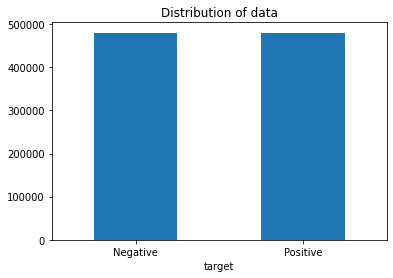

In [ ]:
# Plotting the distribution for dataset.
ax = train.groupby('target')['target'].count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(train['text']), list(train['target'])

In [ ]:
# remove stop words
stopwordlist = ['im','ill','today','day','tomorrow','weekend','yesterday','go','te'] #ill is for i'll

STOPWORDS = set(stopwordlist)
train['text']=train['text'].apply(lambda x: cleaning_stopwords(x))
test['text']=test['text'].apply(lambda x: cleaning_stopwords(x))
valid['text']=valid['text'].apply(lambda x: cleaning_stopwords(x))

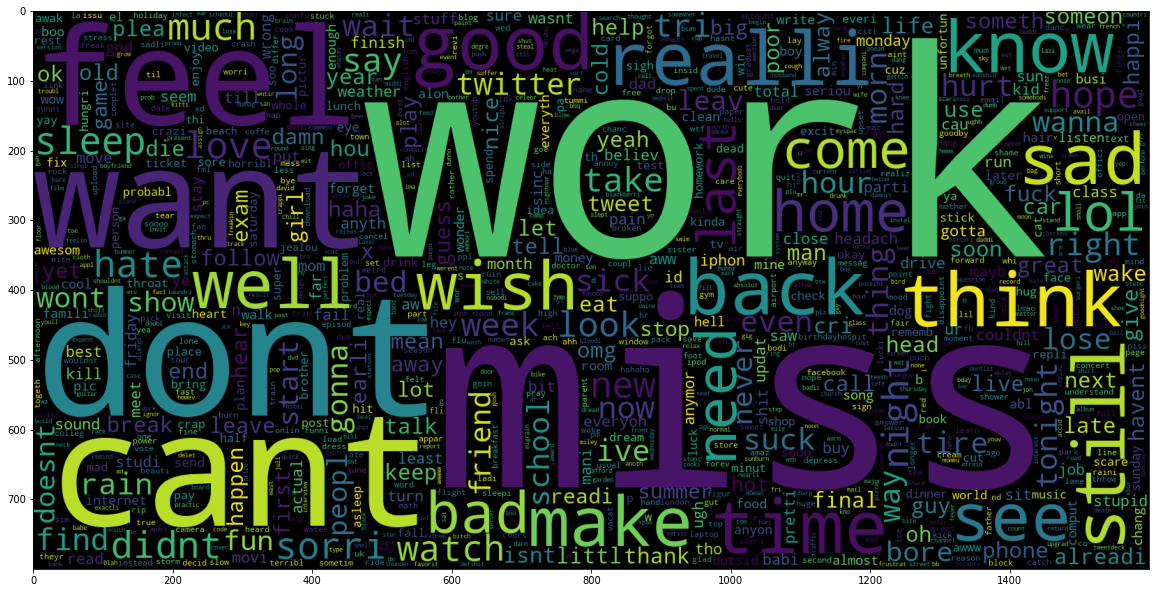

In [ ]:
data_neg = train[train['target'] == 0]
data_neg = data_neg['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

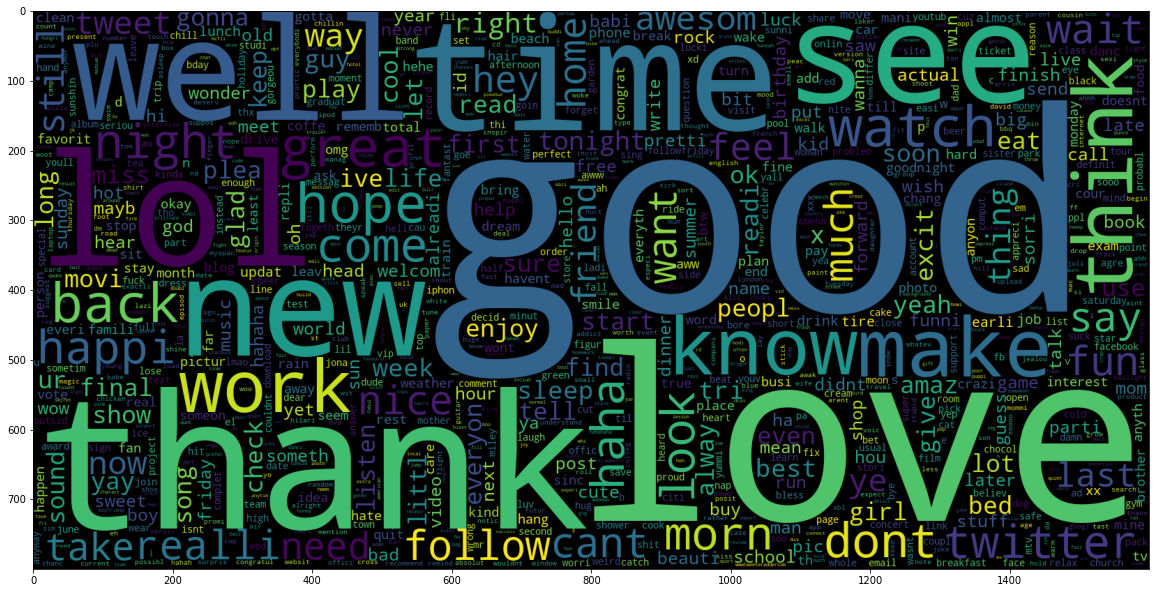

In [ ]:
data_pos= train[train['target'] == 1]
data_pos = data_pos['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
# train test split
X_train = train['text']
y_train = train['target']
X_test = test['text']
y_test = test['target']
X_valid = valid['text']
y_valid = valid['target']

In [ ]:
#Fit the TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [ ]:
train['text']

0         miss cut grass cut grass burn smell smell burn...
1                  chang vote wont bat co rain cricketsweep
2         ty link boost even tho didnt copi whole link t...
3                                               whatt feeel
4                                             circl triangl
                                ...                        
959995                   fleuri get old not hip anymor haha
959996                             land figur ride back car
959997    get off work return apartmentturn tv saw weath...
959998                             far much wine lose chunk
959999                                  wikipedia back phew
Name: text, Length: 960000, dtype: object

In [ ]:
dir = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/Tf-idf/tfidf.joblib"
vectoriser=joblib.load(dir)

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
X_valid = vectoriser.transform(X_valid)

In [ ]:
print(X_train.shape)

(960000, 500000)


In [ ]:
filename = "/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/tfidf.joblib"
joblib.dump(vectoriser, filename)

['/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/tfidf.joblib']

In [ ]:
# Embedding
# Feed a word2vec with tweets
w2v = gensim.models.Word2Vec([tweet.split() for tweet in train['text'].ravel()], size=256, window=5, min_count=2, iter=5)
w2v.save("/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/word2vec.model")

In [ ]:
w2v.most_similar(['love'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5564650297164917),
 ('amaz', 0.5505223870277405),
 ('fave', 0.5417507886886597),
 ('favourit', 0.5148859024047852),
 ('fav', 0.5069469213485718),
 ('favorit', 0.5042974948883057),
 ('loooov', 0.4987568259239197),
 ('lovin', 0.49635154008865356),
 ('awesom', 0.4908970594406128),
 ('looov', 0.4859763979911804)]

In [ ]:
def tweet_vector(tweet):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    tweet = [word for word in tweet if word in w2v.wv.vocab]
    return np.mean(w2v[tweet], axis=0)
def flatten_lists(lst):
    """Remove nested lists."""
    return [item for item in lst]
train_flat = flatten_lists(train['text'])
X_train = list(tweet_vector(train_flat))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77    160000
         1.0       0.76      0.81      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



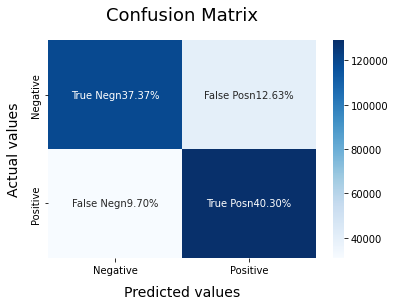

In [ ]:
#Bernoulli Naive Bayes
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

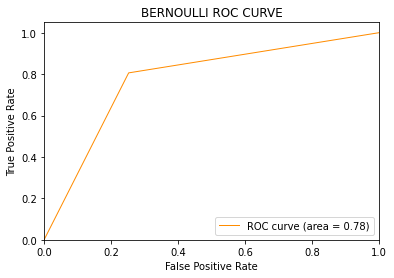

In [ ]:
plot_roc(y_test,y_pred1,"BERNOULLI")

In [ ]:
import joblib
filename = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/BNB/BNB.joblib"
joblib.dump(BNBmodel, filename)

['/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/BNB/BNB.joblib']

              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77    160000
         1.0       0.76      0.81      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



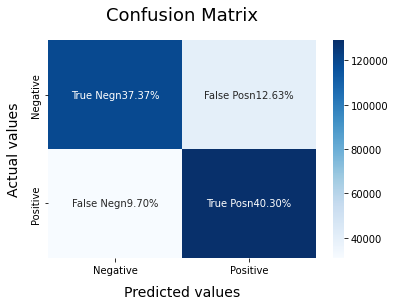

In [ ]:
import joblib

filename = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/BNB/BNB.joblib"
loaded_model = joblib.load(filename)
y_pred1 = loaded_model.predict(X_test)
model_Evaluate(loaded_model)

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78    160000
         1.0       0.77      0.79      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



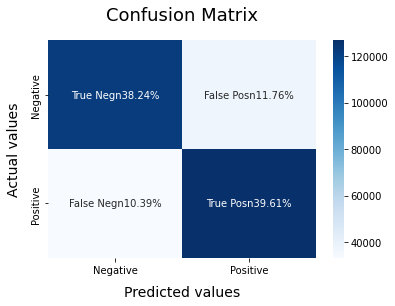

In [ ]:
# Support Vector Machine
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

In [ ]:
import joblib
filename = "/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/SVC/SVC.joblib"
joblib.dump(BNBmodel, filename)

['/content/drive/MyDrive/WPI/CS 539 Final Project/Ensemble/SVC/SVC.joblib']

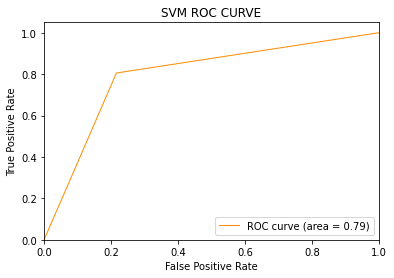

In [ ]:
plot_roc(y_test,y_pred2,"SVM")

              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79    160000
         1.0       0.79      0.81      0.80    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



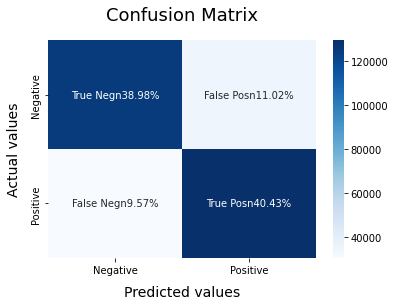

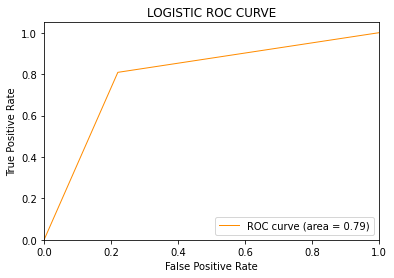

In [ ]:
# Logistic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)
plot_roc(y_test,y_pred3,"LOGISTIC")

In [ ]:
import joblib
filename = "/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/Logistic.joblib"
joblib.dump(LRmodel, filename)

['/content/drive/MyDrive/WPI/CS 539 Final Project/Data Split/Logistic.joblib']